In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import warnings
import numpy as np
import pylab as plt

from astropy.io import fits
from astropy.time import Time
from natsort import natsorted
from astropy.stats import sigma_clip

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from rotate import shiftRotateXYZ
from parabolas import loadLeicaData, fitParabola, parabola
from grid import regridXYZ, regridXYZMasked
from plotting import surfacePlot, barChartPlot
from utils.utils import midPoint, stride, rolling_std, radialMask
from zernikies import zernikeWLS, getZernikeCoeffs
from analyzeActiveSurface import processActiveSurfaceFITSPair
from analysis.March2020.zernike import make_aperture_efficiency, aperture_efficiency_residuals

In [33]:
from scipy.optimize import least_squares

def parabolaFit(x, y, z, guess, bounds=None, 
                max_nfev=10000, ftol=1e-12, 
                xtol=1e-12, verbose=False):
    
    # Set boundaries for the fit parameters.
    if bounds is None:
        inf = np.inf
        pi2 = 2*np.pi
        b1 = [0., -inf, -inf, -inf, -pi2, -pi2]
        b2 = [inf, inf,  inf,  inf,  pi2,  pi2]
        bounds = (b1, b2)
    
    # Robust fit: weights outliers outside of f_scale less
    loss = "soft_l1"
    f_scale = 1.0

    method = fitParabola
    args = (x.flatten(), y.flatten(), z.flatten())
    
    r = least_squares(method,
                      guess,
                      args=args,
                      bounds=bounds,
                      max_nfev=max_nfev,
                      loss=loss,
                      f_scale=f_scale,
                      ftol=ftol,
                      xtol=xtol)
    return r

def parabolaFitIterations(x, y, z, guess=[60., 0, 0, -50., 0, 0], bounds=None, iters=2):
    
    mask = np.isnan(z)
    
    for i in range(iters):
        x_ = x[~mask]
        y_ = y[~mask]
        z_ = z[~mask]
        fit = parabolaFit(x_, y_, z_, guess, bounds=bounds)
        cor = np.hstack((-1*fit.x[1:4],fit.x[4:],0))
        xdr, ydr, zdr = shiftRotateXYZ(x, y, z, cor)
        zp = parabola(xdr, ydr, fit.x[0])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res = sigma_clip(zdr - zp)
        mask = res.mask
    
    return fit, mask

def removeParabolaScan(filename, iters, n=512, guess=[60., 0, 0, -50., 0, 0], bounds=None, fit=None):
    """
    """
    
    orgData, cleanData = loadLeicaData(filename, n=None, numpy=False)
    x = orgData[0]
    y = orgData[1]
    z = orgData[2]
    xg, yg, zg = regridXYZ(x, y, z, n=n)
    xg, yg, zg = shiftRotateXYZ(xg, yg, zg, [0, 0, 0, 0, 0, np.deg2rad(178)])
    fit_, refMask = parabolaFitIterations(xg, yg, zg, guess=guess, bounds=bounds, iters=iters)
    if fit is None:
        fit = fit_
    cor = np.hstack((-1*fit.x[1:4],fit.x[4:],0))
    xgdr, ygdr, zgdr = shiftRotateXYZ(xg, yg, zg, cor)
    zgdr[refMask] = np.nan
    tht = np.arctan2(np.nanmax(zgdr)-np.nanmin(zgdr), np.nanmax(ygdr)-np.nanmin(ygdr))
    xgr, ygr, zgr = shiftRotateXYZ(xgdr, ygdr, zgdr, [0, 0, 0, -tht, 0, 0])
    zp = parabola(xgdr, ygdr, fit.x[0])
    _, _, zpr = shiftRotateXYZ(xgdr, ygdr, zp, [0, 0, 0, -tht, 0, 0])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        diff = sigma_clip(zgr - zpr)
        
    return xgr, ygr, diff, fit

In [145]:
n = 512
iters = 2
nZern = 36
guess = [60., 0., 0., -50., 0., 0.]
iz = 13
izv = -169
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'

In [99]:
%%time
refScan = "{0}/2020_03_16_ref_average.ptx.csv".format(scanDir)
xr, yr, rDiff, rFit = removeParabolaScan(refScan, iters, n=512, guess=[60., 0, 0, -50., 0, 0], bounds=None)

CPU times: user 2min 9s, sys: 1min 53s, total: 4min 2s
Wall time: 16.4 s


In [121]:
sigScan = "{0}/2020_03_16_02:28:31.ptx.csv".format(scanDir)
sigScan = "{0}/2020_03_16_03:02:51.ptx.csv".format(scanDir)
sigScan = "{0}/2020_03_16_05:30:05.ptx.csv".format(scanDir)
sigScan = "{0}/2020_03_16_09:09:14.ptx.csv".format(scanDir)
sigScan = "{0}/2020_03_16_05:54:35.ptx.csv".format(scanDir)
xs, ys, sDiff, sFit = removeParabolaScan(sigScan, iters, n=512, guess=[60., 0, 0, -50., 0, 0], fit=rFit)

<IPython.core.display.Javascript object>


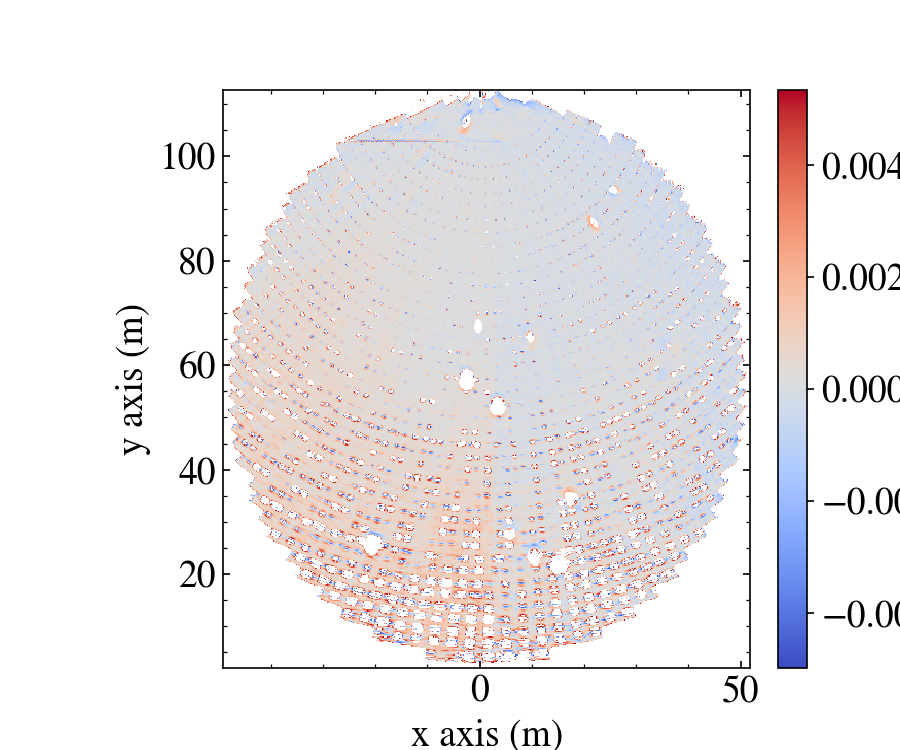

In [122]:
diff = sigma_clip(sDiff - rDiff, 5)
xDiff = xr
yDiff = yr

vmin = np.nanmin(diff)
vmax = np.nanmax(diff)
surfacePlot(xr, yr, diff.T, vMin=vmin, vMax=vmax, midPoint=(vmax+vmin)/2.)

In [146]:
diff_ = np.ma.copy(diff)
diff_[~radialMask(xDiff, yDiff, 50)] = np.nan
diff_ = np.ma.masked_invalid(diff_)

fl = getZernikeCoeffs(diff.filled(0)[::-1].T, nZern, norm='active-surface')
fl_wls = zernikeWLS(xDiff[:,::-1], yDiff[::-1,:], diff_[::-1,::-1], nZern, weighted=False)

expected = np.zeros(37)
expected[iz] = izv
print(izv, (fl_wls*1e6)[iz], fl[iz]*1e6)
barChartPlot(np.arange(4,36), fl_wls[4:36]*1e6, expected=expected[4:36])

-169 -72.25628488372641 -139.025904362042


<IPython.core.display.Javascript object>

In [ ]:
from astropy.convolution import Gaussian2DKernel, convolve

kernel = Gaussian2DKernel(x_stddev=20)
diffSmo = convolve(diff, kernel, preserve_nan=True)

In [ ]:
diff_ = np.ma.copy(diffSmo)
diff_[~radialMask(xDiff, yDiff, 50)] = np.nan
diff_ = np.ma.masked_invalid(diff_)

fl = getZernikeCoeffs(diff_.filled(0)[::-1].T, nZern, norm='active-surface')
fl = np.asarray(fl)

fl_wls = zernikeWLS(xDiff[:,::-1], yDiff[::-1,:], diff_[::-1,::-1], nZern, weighted=False)

expected = np.zeros(37)
expected[iz] = izv
print(izv, (fl_wls*1e6)[iz])
barChartPlot(np.arange(1,36), fl_wls[1:36]*1e6, expected=expected[1:36])

In [138]:
%%time
stds = np.array([0, 1, 4, 8, 12, 16, 20, 24])
stds = np.array([12, 16, 20])
stds = np.arange(2, 20, 2)
flArr = np.zeros((len(stds), nZern+1), dtype=np.float)

for i,std in enumerate(stds):
    if std != 0:
        kernel = Gaussian2DKernel(x_stddev=std)
        diffSmo = convolve(diff, kernel, preserve_nan=True)
    else:
        diffSmo = np.ma.copy(diff)
    diff_ = np.ma.copy(diffSmo)
    diff_[~radialMask(xDiff, yDiff, 49.5)] = np.nan
    diff_ = np.ma.masked_invalid(diff_)

    flArr[i] = zernikeWLS(xDiff[:,::-1], yDiff[::-1,:], diff_[::-1,::-1], nZern, weighted=False)

CPU times: user 50.6 s, sys: 5.52 s, total: 56.1 s
Wall time: 40.7 s


-107.82327388912546


<IPython.core.display.Javascript object>


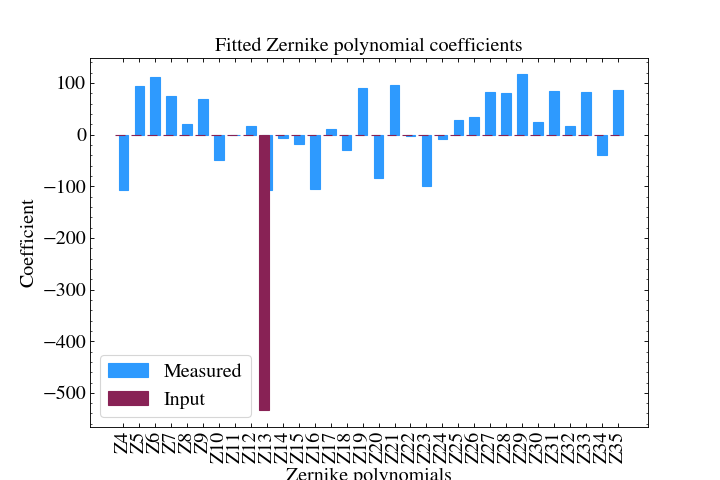

In [139]:
print(flArr.mean(axis=0)[iz]*1e6)
barChartPlot(np.arange(4,36), flArr.mean(axis=0)[4:36]*1e6, expected=expected[4:36])

-107.08605113744638


<IPython.core.display.Javascript object>


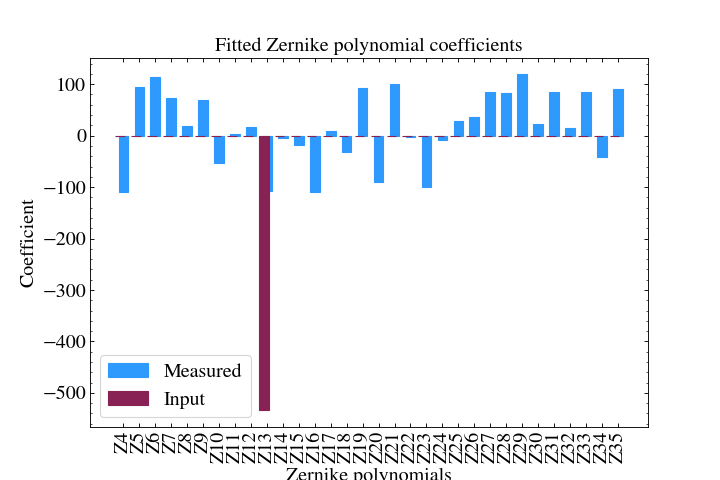

In [140]:
scale_bias = 1. - 0.6*stds/np.max(stds)
fl_avg_w = np.average(flArr, axis=0, weights=scale_bias)
print(fl_avg_w[iz]*1e6)
barChartPlot(np.arange(4,36), fl_avg_w[4:36]*1e6, expected=expected[4:36])

[1.         1.2        1.33505546 1.44       1.52704966 1.60206655
 1.66836035 1.728      1.78237307]
-108.26213618146271


<IPython.core.display.Javascript object>


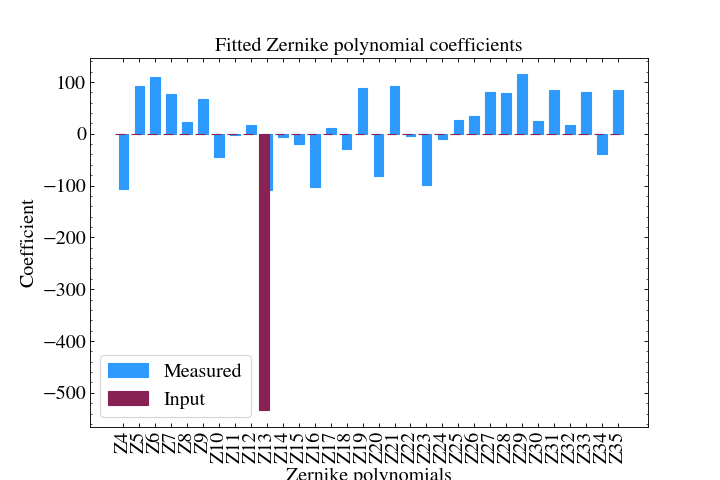

In [141]:
beta = 1.2
#scale_bias2 = np.hstack((1, np.power(beta,-1.+np.log2(stds[1:]/1.))))
scale_bias2 = np.power(beta,-1.+np.log2(stds/1.))
print(scale_bias2)
fl_avg_w = np.average(flArr, axis=0, weights=scale_bias2)
print(fl_avg_w[iz]*1e6)
barChartPlot(np.arange(4,36), fl_avg_w[4:36]*1e6, expected=expected[4:36])

In [142]:
flArr[:,iz]*1e6*scale_bias, flArr[:,iz]*1e6*scale_bias2, flArr[:,iz]*1e6

(array([-97.79964622, -90.47560702, -83.78862703, -77.82182882,
        -71.78495627, -65.21978369, -58.48545567, -51.84359428,
        -45.29680782]),
 array([-104.78533524, -125.27391742, -139.82807953, -152.81377296,
        -164.42878927, -174.14405602, -182.95277905, -191.96942339,
        -201.83952592]),
 array([-104.78533524, -104.39493118, -104.73578379, -106.12067567,
        -107.6774344 , -108.69963948, -109.66022938, -111.09341631,
        -113.24201955]))

In [144]:
stds

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])

In [143]:
best_idx = np.argmax(flArr[:,iz]*1e6*scale_bias)
print(flArr[best_idx,iz]*1e6, izv - flArr[best_idx,iz]*1e6)
best_idx = np.argmin(flArr[:,iz]*1e6*scale_bias2)
print(flArr[best_idx,iz]*1e6, izv - flArr[best_idx,iz]*1e6)

-113.24201955449546 -55.75798044550454
-113.24201955449546 -55.75798044550454


-114.5775246514901


<IPython.core.display.Javascript object>


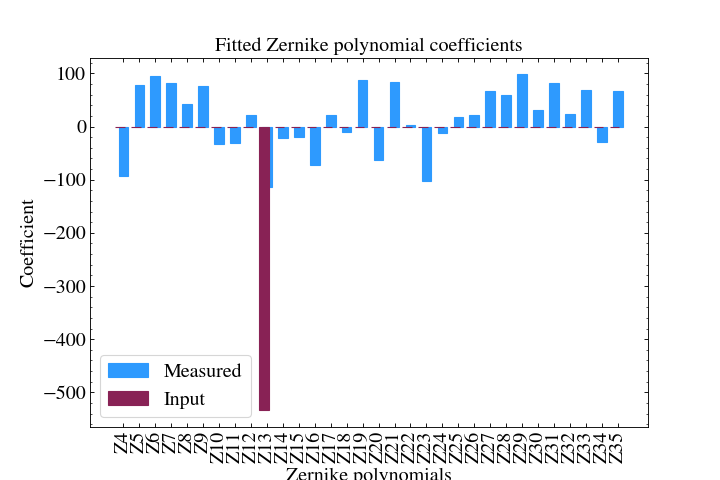

In [132]:
print(flArr[-1,iz]*1e6)
barChartPlot(np.arange(4,36), flArr[-1,4:36]*1e6, expected=expected[4:36])

<IPython.core.display.Javascript object>


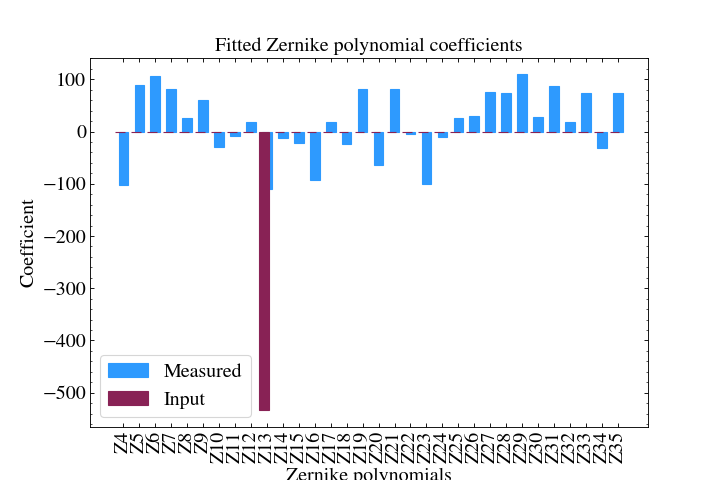

In [133]:
barChartPlot(np.arange(4,36), flArr[2,4:36]*1e6, expected=expected[4:36])